 #### Coded by: Vikranth

In [1]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib notebook

(180000, 15)
(86757, 3)
(86757, 15)


<IPython.core.display.Javascript object>


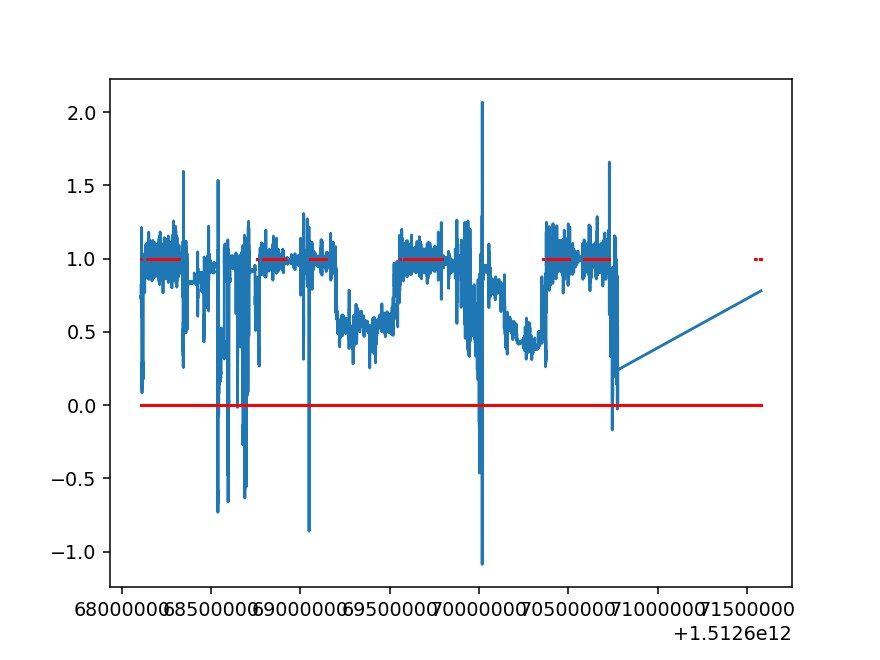

In [2]:
participant_1 = pd.read_pickle('Participant_1.pkl')
#print(participant_1)
labels_1 = np.load('Participant_1_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'r.', ms = 1)
plt.show()

Counter({0.0: 65815, 1.0: 17721, 2.0: 3221})
(65815, 3)
(65815, 15)


<IPython.core.display.Javascript object>


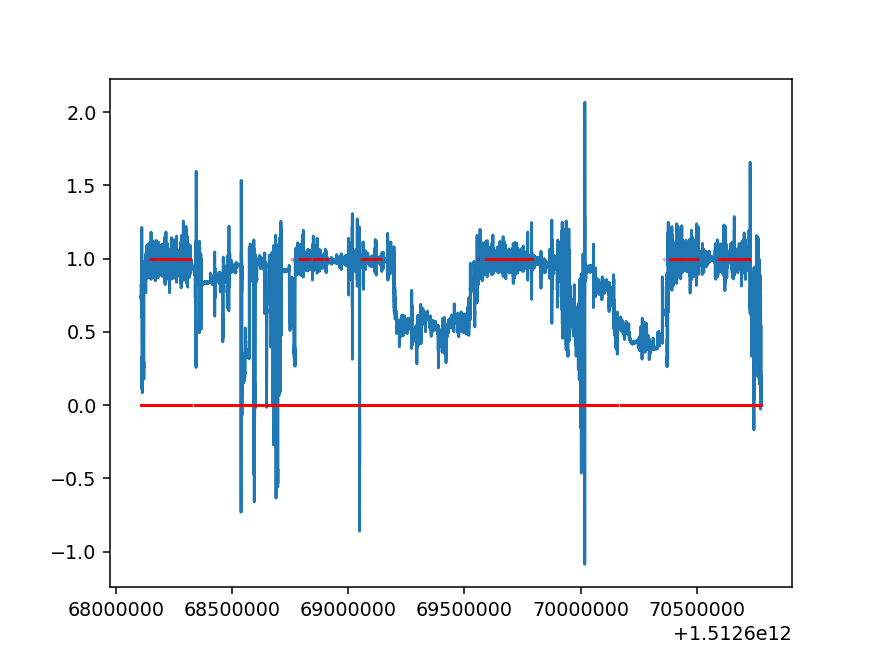

In [3]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
key_labels = labels_1[np.where(missing_1 == 0),:].reshape((-1,3))

print(key_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],key_labels[:,2],'r.', ms = 0.1)
plt.show()

In [4]:
Counter(key_labels[:,1])

Counter({0.0: 62093,
         8.0: 398,
         9.0: 4,
         13.0: 20,
         20.0: 2,
         32.0: 459,
         37.0: 104,
         38.0: 29,
         39.0: 345,
         40.0: 30,
         46.0: 11,
         48.0: 6,
         49.0: 10,
         50.0: 5,
         51.0: 1,
         54.0: 3,
         55.0: 2,
         57.0: 1,
         65.0: 200,
         66.0: 35,
         67.0: 62,
         68.0: 72,
         69.0: 247,
         70.0: 42,
         71.0: 60,
         72.0: 90,
         73.0: 164,
         74.0: 6,
         75.0: 18,
         76.0: 89,
         77.0: 55,
         78.0: 139,
         79.0: 141,
         80.0: 39,
         81.0: 1,
         82.0: 114,
         83.0: 129,
         84.0: 188,
         85.0: 62,
         86.0: 27,
         87.0: 45,
         88.0: 1,
         89.0: 41,
         100.0: 14,
         160.0: 174,
         174.0: 2,
         186.0: 3,
         189.0: 7,
         190.0: 17,
         191.0: 6,
         221.0: 1,
         222.0: 1})

In [28]:
# 0 - No key
# 1 - AlphaNumeric
# 2 - Special Characters

new_labels = np.copy(key_labels[:,1])
labels_l = new_labels.shape[0]
for i in range(0,labels_l):
    if (new_labels[i] == 0):
        new_labels[i] = 0
    elif ((new_labels[i] >= 65) and (new_labels[i] <= 90)):
        new_labels[i] = 1
    elif ((new_labels[i] >= 48) and (new_labels[i] <= 57)):
        new_labels[i] = 1  #2
    else:
        new_labels[i] = 2
        
print(Counter(new_labels))
print(np.shape(new_labels))

Counter({0.0: 62093, 1.0: 2095, 2.0: 1627})
(65815,)


In [29]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 5
stride = 5

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
key_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    key_labels_cp[k] = np.amax(new_labels[i:i+window])
    k=k+1
    
print (data_slide.shape)
print(key_labels_cp.shape)

(13163, 5, 12)
(13163, 1)


In [30]:
print(Counter(key_labels_cp[:,0]))

Counter({0.0: 10533, 1.0: 1452, 2.0: 1178})


<IPython.core.display.Javascript object>


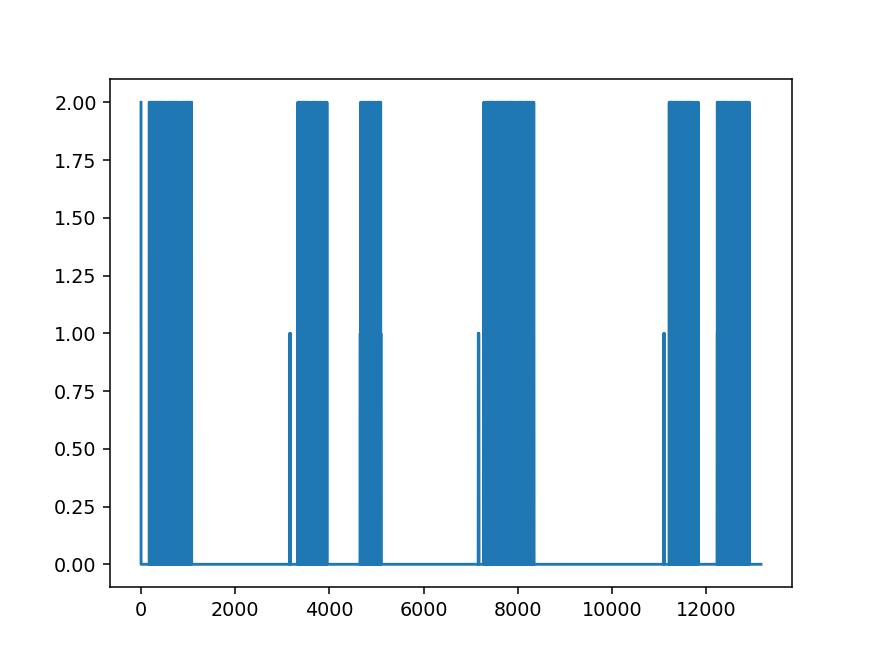

In [31]:
plt.figure()
plt.plot(key_labels_cp[:,0])
plt.show()

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [41]:
z = 13000
X_train0 = data_slide[:z]
Y_train = key_labels_cp[0:z].reshape(-1).astype(np.uint8)
X_test0 = data_slide[z:]
Y_test = key_labels_cp[z:]
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_test0))
print(np.shape(Y_test))
num_classes = 3
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

(13000, 5, 12)
(13000,)
(163, 5, 12)
(163, 1)


In [56]:
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    #_, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))
    
    print (np.shape(X_train))
    print (np.shape(X_train))
    return X_train, X_valid

In [43]:
def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(p))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization()) #added
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3),    # Original Kernel size(1,5)
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))

def model_MLP(model, num_hidden_mlp,p):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(p))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))
    

In [67]:
batch_size = 1024
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'CNN'
#network_type = 'ConvLSTM'
network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)

5
12
LSTM
(13000, 5, 12)
(13000, 5, 12)


In [68]:
p=0.3 #Dropout
b = 0 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp,p) 
       
model_output(model)    
model.summary()


building the model ... 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 64)             19712     
_________________________________________________________________
dropout_27 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 195       
Total params: 52,931
Trainable params: 52,931
Non-trainable params: 0
_________________________________________________________________


In [69]:
epochs = 100

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

H = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_test, Y_test))


Train on 13000 samples, validate on 163 samples
Epoch 1/100
13000/13000 [==============================] - 4s - loss: 0.8778 - acc: 0.7027 - val_loss: 0.5744 - val_acc: 0.8773
Epoch 2/100
13000/13000 [==============================] - 2s - loss: 0.6713 - acc: 0.7872 - val_loss: 0.3969 - val_acc: 0.9448
Epoch 3/100
13000/13000 [==============================] - 2s - loss: 0.6362 - acc: 0.7920 - val_loss: 0.4107 - val_acc: 0.9755
Epoch 4/100
13000/13000 [==============================] - 2s - loss: 0.6153 - acc: 0.7946 - val_loss: 0.3184 - val_acc: 1.0000
Epoch 5/100
13000/13000 [==============================] - 2s - loss: 0.5938 - acc: 0.7950 - val_loss: 0.3034 - val_acc: 1.0000
Epoch 6/100
13000/13000 [==============================] - 2s - loss: 0.5659 - acc: 0.7952 - val_loss: 0.2698 - val_acc: 0.9939
Epoch 7/100
13000/13000 [==============================] - 2s - loss: 0.5386 - acc: 0.7963 - val_loss: 0.2242 - val_acc: 0.9939
Epoch 8/100
13000/13000 [==============================]

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))


[[157   5   1]
 [  0   0   0]
 [  0   0   0]]
the mean-f1 score: 0.33


C:\Users\Vikranth\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<IPython.core.display.Javascript object>


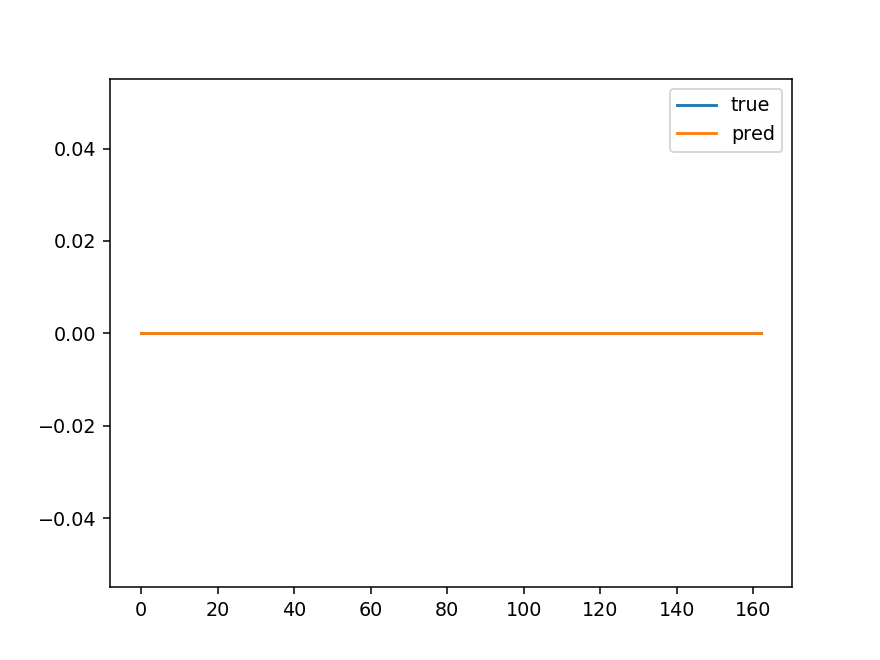

In [71]:
plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")

#plt.plot(typing_labels_cp[60000:], label="label")

plt.legend()
plt.show()

In [73]:
model.save('LSTM_100.h5')